In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
# ROOT_DIR = os.path.abspath("../../")
ROOT_DIR = os.path.abspath("./")  # currnet directory
print(ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# directory of dataset 
DATASET_DIR = os.path.join(ROOT_DIR,"datasets/apples")
print(DATASET_DIR)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/berkay/anaconda3/envs/old

/home/berkay/code/freelance/RaspML/ubuntuProjects/Mask_R_CNN_in_Fruit_Counting/Mask_RCNN/samples/fruit
/home/berkay/code/freelance/RaspML/ubuntuProjects/Mask_R_CNN_in_Fruit_Counting/Mask_RCNN/samples/fruit/datasets/apples


Using TensorFlow backend.


# Train

## Configurations

In [2]:
class FruitConfig(Config):
    """Configuration for training on the fruit dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "apple"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1   ####

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + fruit

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

config = FruitConfig()
config.display()



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset
override the following methods:
* load_fruit()
* load_mask()
* image_reference()

In [4]:
import csv
import skimage.draw

class FruitDataset(utils.Dataset):
      def load_fruit(self, dataset_dir, subset):
          """Load a subset of the fruit dataset.
          dataset_dir: Root directory of the dataset.
          subset: Subset to load: train,val or test
          """
          # Add classes. We have only one class to add.
          self.add_class("apple", 1, "apple")

          # Train, validation or test dataset?
          assert subset in ["train", "val","test"]
          dataset_dir = os.path.join(dataset_dir, subset)
          print(dataset_dir)
          
          # Load annotations
          img_file_list=[]
          ano_file_list=[]
          for name in os.listdir(dataset_dir):
              if name.endswith(".png"):
                 img_file_list.append(name)
              elif name.endswith(".csv"):
                 ano_file_list.append(name)
          
       
          for name in img_file_list:
              index_=name.index("_")
              pre_name=name[:index_+3].strip()
#               print(pre_name)

#               try:
#                  ano_index=ano_file_list.index(pre_name)
#               except:
#                  continue
              
              if (pre_name+".csv") not in ano_file_list:
                  continue
                
              r_list=[]
              c_list=[]
              radius_list=[]
              ano_path=os.path.join(dataset_dir, pre_name+".csv")
              with open(ano_path) as f:  ####
                  f_csv=csv.reader(f)
                  headers=next(f_csv)
                  for row in f_csv:
                      r_list.append(row[2])  ##### subscript, row is y, column is x
                      c_list.append(row[1])
                      radius_list.append(row[3])
              
#               print("r_list:",r_list)
#               print("c_list:",c_list)
#               print("radius_list:",radius_list)
              
              image_path = os.path.join(dataset_dir, name)
              image = skimage.io.imread(image_path)
              height, width = image.shape[:2] 
#               print("height:",height,"width:",width)   # 202*308
              
              self.add_image(
                  "apple",
                  image_id=name,  # use file name as a unique image id
                  path=image_path,
                  width=width, height=height,
                  r=r_list,
                  c=c_list,
                  radius=radius_list)  ######
             
       
      def load_mask(self, image_id):
          """Generate instance masks for an image.
             Returns:
             masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
             class_ids: a 1D array of class IDs of the instance masks.
          """
          # If not a balloon dataset image, delegate to parent class.
          image_info = self.image_info[image_id]
          if image_info["source"] != "apple":
              return super(self.__class__, self).load_mask(image_id)

          # Convert circles to a bitmap mask of shape
          # [height, width, instance_count]
          info = self.image_info[image_id]
#           print("len(r):",len(info["r"]))
#           print(info["r"])
#           print(info["c"])
#           print(info["radius"])
          mask = np.zeros([info["height"], info["width"], len(info["r"])],
                          dtype=np.uint8)
#           print("mask_shape:",mask.shape)
#           index=0
          for index in range(len(info["r"])):
              # Get indexes of pixels inside the circle and set them to 1
#               print("r:",info["r"][index])
#               print("c:",info["c"][index])
#               print("radius:",info["radius"][index])
              rr, cc = skimage.draw.circle(float(info["r"][index]), float(info["c"][index]), float(info["radius"][index]),mask.shape)  
              mask[rr, cc, index] = 1

          # Return mask, and array of class IDs of each instance. Since we have
          # one class ID only, we return an array of 1s
          return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
          
      
      def image_reference(self, image_id):
          """Return the path of the image."""
          info = self.image_info[image_id]
          if info["source"] == "apple":
              return info["path"]
          else:
              super(self.__class__, self).image_reference(image_id)
      

In [5]:
# Load Training dataset.
dataset_train = FruitDataset()
dataset_train.load_fruit(DATASET_DIR, "train")

dataset_train.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))

/home/berkay/code/freelance/RaspML/ubuntuProjects/Mask_R_CNN_in_Fruit_Counting/Mask_RCNN/samples/fruit/datasets/apples/train
Images: 896
Classes: ['BG', 'apple']


In [6]:
### Load validation dataset
dataset_val = FruitDataset()
dataset_val.load_fruit(DATASET_DIR, "val")

# Must call before using the dataset
dataset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

/home/berkay/code/freelance/RaspML/ubuntuProjects/Mask_R_CNN_in_Fruit_Counting/Mask_RCNN/samples/fruit/datasets/apples/val
Images: 112
Classes: ['BG', 'apple']


## Create Training Model

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights
model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

## Training

In [ ]:
########Transfer learning 
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. We can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/berkay/code/freelance/RaspML/ubuntuProjects/Mask_R_CNN_in_Fruit_Counting/Mask_RCNN/samples/fruit/logs/apple20210528T2132/mask_rcnn_apple_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_b

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/keras



Epoch 1/5


/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circ

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool 

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will b

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `np.b

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will b

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool 

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised inst

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised inst

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised inst

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will b

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised inst

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is 

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence 

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised inst

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more detail

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_

/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/ipykernel_launcher.py:100: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
/home/berkay/anaconda3/envs/olderPython/lib/python3.7/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_

In [0]:
# Fine tune all layers
# Passing layers="all" trains all layers. 
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=5, 
#             layers="all")

In [0]:
# Save weights
# Typically not needed because callbacks save after every epoch, Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_apples.h5")
# model.keras_model.save_weights(model_path)

# Detection

In [7]:
### Override the training configurations with a few changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [8]:
### Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

In [ ]:
### Create model object in inference mode.
with tf.device(DEVICE):
  model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=inference_config)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])

Loading weights from  /home/berkay/code/freelance/RaspML/ubuntuProjects/Mask_R_CNN_in_Fruit_Counting/Mask_RCNN/samples/fruit/mask_rcnn_coco.h5


In [1]:
### Run Detection
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))

# ground truth
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))   ######## dataset_train.class_names

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

NameError: name 'random' is not defined

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


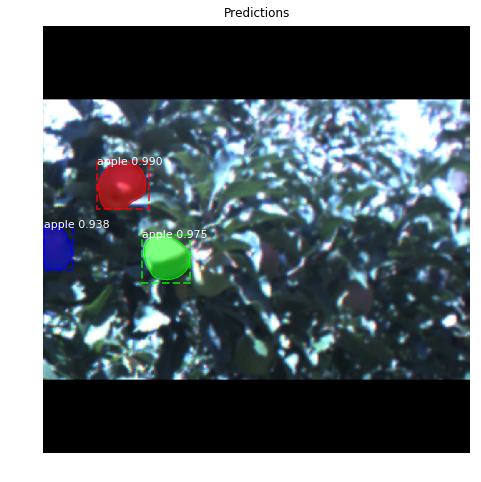

In [22]:
# Run object detection
results = model.detect([original_image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Predictions")

## Evaluation

In [29]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
print(image_ids)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)   ###### from the validation set
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.4961832672357559


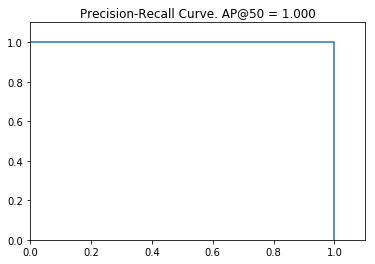

In [26]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

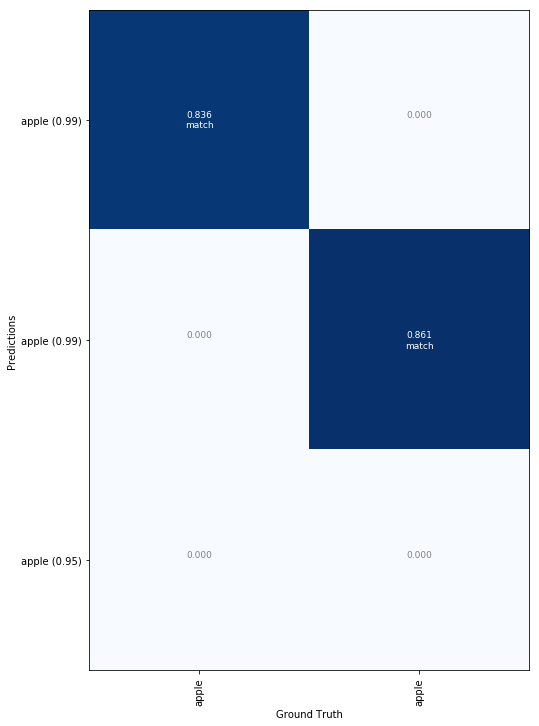

In [28]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_val.class_names)